In [67]:
import pandas as pd
import numpy as np
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tools.eval_measures import rmse
import matplotlib.pyplot as plt
from Codigo import *
import seaborn as sn
sn.set(style="whitegrid")

### Cargar Datos

In [68]:
Datos = Tachos('../Alemania_Reducida.csv')
data = Datos[['PIB (US$ a precios constantes de 2010)','Gasto de consumo final de los hogares (US$ a precios constantes de 2010)','Gasto nacional bruto (US$ a precios constantes de 2010)']].dropna(axis = 0)
data.columns = ['PIB','Inversión','Gasto']
data.dropna(axis =1, inplace= True)
data.index = pd.date_range(start='1970-12-31', periods=len(data), freq='Y')

### Analisis de Estacionariedad a las Variables

### Amalisis de Correlacion de las Variables

### Analisis de Cointegración

In [69]:
print('Al 99% de confianza')
Johansen_Test(data,1,0,1)

Al 99% de confianza
Matriz de Valores Criticos vs Maximo Valor Propio
            cvm     eigv        Hipotesis
r = 0     15.0006    18.5001    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     17.1481    11.5092    No hay suficiente evidencia para rechazar la hipótesis nula de r = 1.
r = 2     21.7465    1.9887    No hay suficiente evidencia para rechazar la hipótesis nula de r = 2.
Tabla de Valores Criticos vs Traza Estadistica
            cvt     TS          Hipotesis
r = 0     16.1619    31.9981    Se rechaza r = 0, existe mas de 0 relación/nes de cointegración
r = 1     18.3985    13.498    No hay suficiente evidencia para rechazar la hipótesis nula de r = 1.
r = 2     23.1485    1.9887    No hay suficiente evidencia para rechazar la hipótesis nula de r = 2.


### Modelo Inicial

In [76]:

lag_order = select_order(data, exog = data['Inversión'], maxlags= 10, deterministic= 'n', seasons= 0)

print(lag_order)

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 1, BIC -> 1, FPE -> 1, HQIC ->  1>


In [77]:
model = VECM(data,exog = data['Inversión'] ,coint_rank= 2, k_ar_diff= 1)
result = model.fit()
alpha_matrix = result.alpha
print("Matriz de Coeficientes de Corrección de Errores (alpha):")
print(alpha_matrix)


Matriz de Coeficientes de Corrección de Errores (alpha):
[[-1.11230759e-01 -8.41814259e-01]
 [-3.60336225e-16 -1.00000000e+00]
 [-2.77293084e-02 -1.38594418e+00]]


In [78]:
print(result.summary())

Det. terms outside the coint. relation & lagged endog. parameters for equation PIB
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
exog1            1.3307      0.211      6.311      0.000       0.917       1.744
L1.PIB          -0.3981      0.204     -1.954      0.051      -0.797       0.001
L1.Inversión    -0.6844      0.408     -1.679      0.093      -1.484       0.115
L1.Gasto         0.5933      0.293      2.028      0.043       0.020       1.167
Det. terms outside the coint. relation & lagged endog. parameters for equation Inversión
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
exog1            1.0000   3.82e-15   2.62e+14      0.000       1.000       1.000
L1.PIB        1.793e-14   3.69e-15      4.860      0.000    1.07e-14    2.52e-14
L1.Inversión  1.92

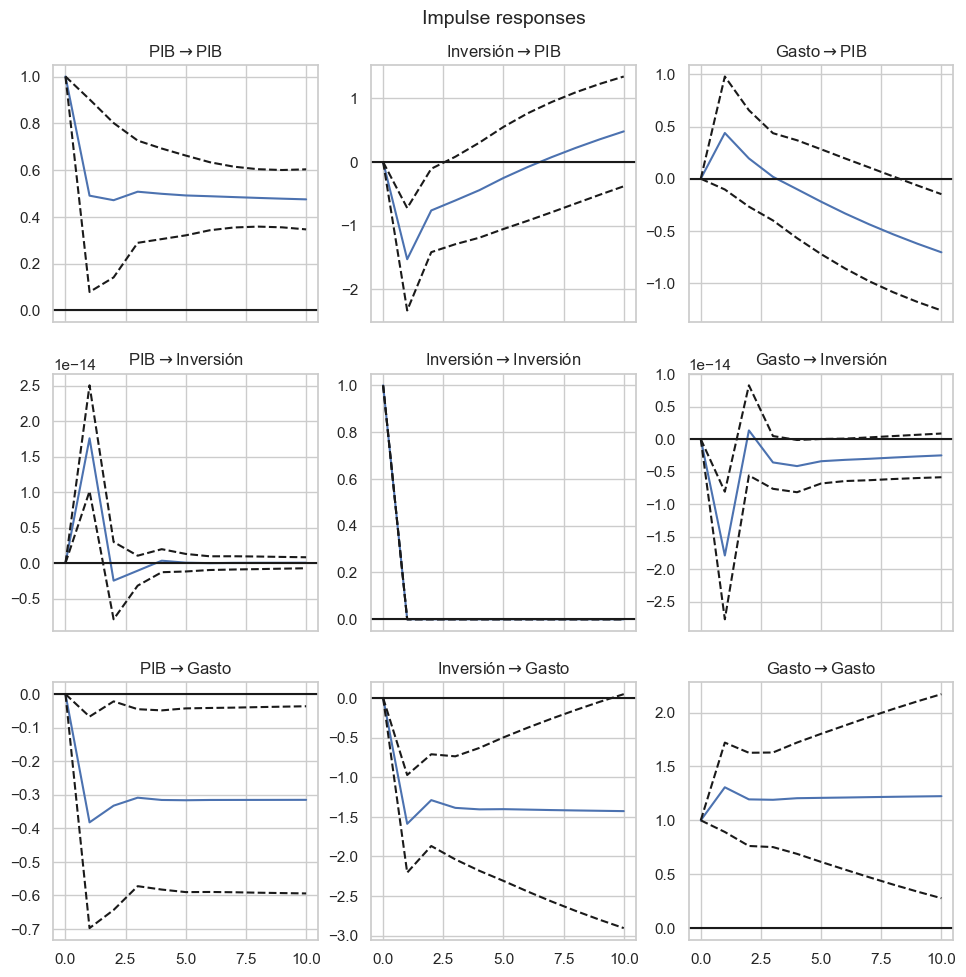

In [73]:
# Paso 6: Análisis de Impulsos-Respuestas
irf = result.irf(periods=10)
irf.plot()
plt.show()